In [37]:
import numpy as np
import pandas as pd
import builtins
import pyfolio as pf
# from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
#                      INFO, WARNING, DEBUG, ERROR)
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
# import pyfolio as pf
# from pyfolio.utils import extract_rets_pos_txn_from_zipline
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
def rolling_sharpe(ret):
    return np.multiply(np.divide(ret.mean(), ret.std()), np.sqrt(252))

def get_rolling_stats(result, r_window):
    result["rolling_sharpe"] = result["portfolio_value"].pct_change().rolling(r_window).apply(rolling_sharpe)
    result["rolling_vol"] = result["portfolio_value"].pct_change().rolling(r_window).std()
    stats = [result.rolling_sharpe.mean(), result.portfolio_value.mean(), result.rolling_vol.mean()]
    return result, stats

def show_rolling_stats(result, r_window):
    result, stats = get_rolling_stats(result, r_window)
    fig, ax = plt.subplots(1, 3, figsize=(18,4))
    result['rolling_sharpe'].plot(ax = ax[0], title='Rolling sharpe')
    result['rolling_vol'].plot(ax = ax[1], title='Rolling vol')
    result['portfolio_value'].plot(ax = ax[2], title='Portfolio value')
    plt.show()
    return result

## Varaible Initialization

In [39]:
import warnings
warnings.filterwarnings('ignore')

start_date = pd.to_datetime('2010-05-10 00:00:00.000000', format='%Y-%m-%d %H:%M:%S.%f')
end_date= pd.to_datetime('2021-07-30 00:00:00.000000', format='%Y-%m-%d %H:%M:%S.%f')

capital_base=100_000
symb = 'sp100_data'
bollinger_window = 30
bollinger_dev = 2

In [4]:
!zipline ingest -b sp100_bundle

[2023-12-18T00:17:00+0600-INFO][zipline.data.bundles.core]
 Ingesting sp100_bundle
Loading custom pricing data:   [------------------------------------]    0%/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/data/bcolz_daily_bars.py:341: UserWarning: Ignoring 684 values because they are out of bounds for uint32:
                    open         high          low        close        volume
timestamp                                                                   
2010-01-06   524.150024   525.359985   523.090027   524.309998  4.972660e+09
2010-01-07   523.950012   526.820007   521.630005   526.340027  5.270680e+09
2010-01-08   525.789978   527.940002   524.270020   527.760010  4.389590e+09
2010-01-12   526.940002   526.940002   522.289978   524.289978  4.716160e+09
2010-01-15   529.390015   529.400024   522.059998   524.109985  4.758730e+09
...                 ...          ...          ...          ...           ...
2021-07-06  1995.859985  1996.780029  1978.349976  1993.59

In [16]:
def initialize(context):
    context.i = 0
    context.asset = symbol(symb)
    context.bollinger_window = bollinger_window  # Bollinger Bands window
    context.bollinger_dev = bollinger_dev  # Number of standard deviations for Bollinger Bands

def handle_data(context, data):
    context.i += 1
    if context.i < context.bollinger_window:
        return
    buy_signal = False
    sell_signal = False
    # Get historical price data
    prices = data.history(context.asset, 'close', context.bollinger_window + 1, frequency='1d')
    # print(prices)
    # Calculate Bollinger Bands
    sma = prices.mean()
    rolling_std = prices.std()
    upper_band = sma + (context.bollinger_dev * rolling_std)
    lower_band = sma - (context.bollinger_dev * rolling_std)

    # Get the current price
    current_price = data.current(context.asset, 'close')

    # Generate signals based on Bollinger Bands
    if current_price > upper_band:
        order_target_percent(context.asset, -0.5)  # Short position
        buy_signal=True
    elif current_price < lower_band:
        order_target_percent(context.asset, 0.5)  # Long position
        sell_signal=True
    else:
        order_target_percent(context.asset, 0)  # Close position

    # Record the values for later analysis
    record(price=current_price, upper=upper_band, lower=lower_band)
    record(
        AAPL=current_price,
        lower_band=lower_band, upper_band=upper_band,
        sell_signal = sell_signal,
        buy_signal = buy_signal,
        price_hist=prices
    )

In [6]:
!zipline bundles

csvdir <no ingestions>
quandl 2023-12-12 14:51:06.970977
quandl 2023-12-11 18:58:51.384085
quandl 2023-12-11 18:58:18.790981
quandl 2023-12-11 17:27:05.201175
quandl 2023-12-11 17:16:04.140642
quandl 2023-12-11 09:19:57.807125
quandl 2023-12-11 09:18:50.209032
quandl 2023-12-11 09:14:10.865540
quandl 2023-12-11 06:27:30.829838
quandl 2023-12-10 12:31:04.001536
quandl 2023-12-10 12:22:46.640028
quantopian-quandl <no ingestions>
sp100_bundle 2023-12-17 18:17:00.046242
sp100_bundle 2023-12-17 18:10:01.453839
sp100_bundle 2023-12-17 18:08:49.161934
sp100_bundle 2023-12-17 18:02:48.157623
sp100_bundle 2023-12-17 17:54:07.966926
sp100_bundle 2023-12-17 17:49:57.270241
sp100_bundle 2023-12-15 10:12:49.964266
sp100_bundle 2023-12-12 14:30:55.178197


In [17]:
# Run the algorithm
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp100_bundle',
)

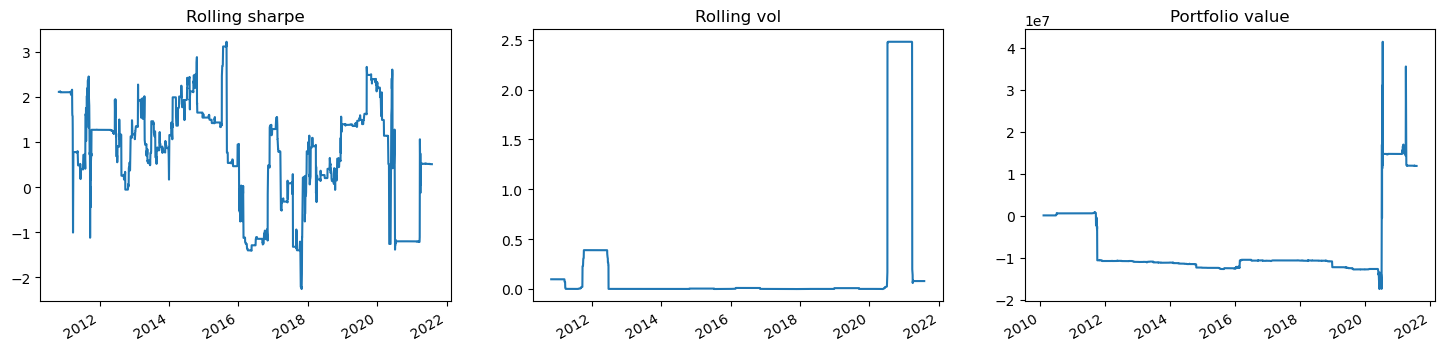

In [18]:
result = show_rolling_stats(result, 180)

In [63]:
def initialize(context):
    context.i = 0
    context.asset=symbol(symb)
    context.bollinger_window = 25  # Bollinger Bands window
    context.bollinger_dev = 2.5  # Number of standard deviations for Bollinger Bands
    context.macd_short_window = 16
    context.macd_long_window = 32
    context.macd_signal_window = 11
    context.max_volatility = 0.03
    
def calculate_macd(prices, short_window, long_window, signal_window):
    exp12 = prices.ewm(span=short_window, adjust=False).mean()
    exp26 = prices.ewm(span=long_window, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

    
def handle_data(context, data):
    buy_signal = False
    sell_signal = False
    
    # Get historical price data
    prices = data.history(context.asset, 'close', max(context.bollinger_window,context.macd_long_window, context.macd_signal_window) + 1, frequency='1d')

    # Calculate Bollinger Bands
    sma = prices[-context.bollinger_window:].mean()
    rolling_std = prices[-context.bollinger_window:].std()
    upper_band = sma + (context.bollinger_dev * rolling_std)
    lower_band = sma - (context.bollinger_dev * rolling_std)

    # Calculate MACD
    close_prices = prices[-context.macd_long_window:]
    macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

    # Calculate historical returns for volatility calculation
    returns = prices.pct_change().dropna()

    # Calculate volatility as the standard deviation of returns
    volatility = returns.std()

    # Get the current price
    current_price = data.current(context.asset, 'close')

    open_orders = get_open_orders()
    # Check if the asset is still tradable and if volatility is below a certain threshold
    if data.can_trade(context.asset) and volatility < context.max_volatility:
        cash = context.portfolio.cash
        # Generate signals based on Bollinger Bands and MACD
        if current_price > upper_band and macd.iloc[-1] > signal.iloc[-1] and macd.iloc[-2] < signal.iloc[-2]:
            order_target(context.asset, -(cash // current_price))  # Short position
            sell_signal = True
        elif current_price < lower_band and macd.iloc[-1] < signal.iloc[-1] and macd.iloc[-2] > signal.iloc[-2]:
            order_target(context.asset, cash // current_price)  # Long position
            buy_signal = True
        else:
            order_target(context.asset, 0)  # Close position

    # Record the values for later analysis

    record(
        sp100=current_price,
        lower_band=lower_band, upper_band=upper_band,
        sell_signal=sell_signal,
        buy_signal=buy_signal,
        price_hist=prices,
        volatility=volatility
    )


In [64]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp100_bundle',
)

In [50]:
result.portfolio_value

2010-05-10 20:00:00+00:00    100000.000000
2010-05-11 20:00:00+00:00    100000.000000
2010-05-12 20:00:00+00:00    100000.000000
2010-05-13 20:00:00+00:00    100000.000000
2010-05-14 20:00:00+00:00    100000.000000
                                 ...      
2021-07-26 20:00:00+00:00     98498.383535
2021-07-27 20:00:00+00:00     98498.383535
2021-07-28 20:00:00+00:00     98498.383535
2021-07-29 20:00:00+00:00     98498.383535
2021-07-30 20:00:00+00:00     98498.383535
Name: portfolio_value, Length: 2827, dtype: float64

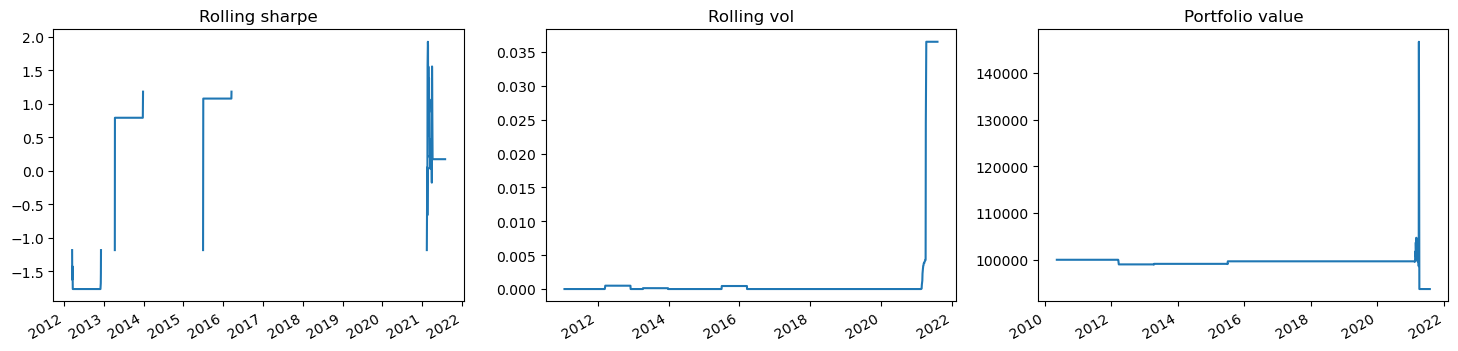

In [65]:
result = show_rolling_stats(result, 180)

In [ ]:
 context.bollinger_window = 15  # Bollinger Bands window
    context.bollinger_dev = 1.5  # Number of standard deviations for Bollinger Bands
    context.macd_short_window = 8
    context.macd_long_window = 20
    context.macd_signal_window = 7
    context.max_volatility = 0.01
    

In [67]:
bollinger_window_values = [15]  # Test different Bollinger Bands window sizes
bollinger_dev_values = [1.5]  # Test different standard deviations for Bollinger Bands
macd_short_window_values = [8]  # Test different short-term MACD window sizes
macd_long_window_values = [20]  # Test different long-term MACD window sizes
macd_signal_window_values = [7]  # Test different MACD signal window sizes
max_volatility_values = [0.01]

In [77]:
bollinger_window_values = [15, 20, 25]  # Test different Bollinger Bands window sizes
bollinger_dev_values = [1.5, 2, 2.5]  # Test different standard deviations for Bollinger Bands
macd_short_window_values = [8, 12, 16]  # Test different short-term MACD window sizes
macd_long_window_values = [20, 26, 32]  # Test different long-term MACD window sizes
macd_signal_window_values = [7, 9, 11]  # Test different MACD signal window sizes
max_volatility_values = [0.01, 0.02, 0.03]

In [68]:
def calculate_macd(prices, short_window, long_window, signal_window):
                            exp12 = prices.ewm(span=short_window, adjust=False).mean()
                            exp26 = prices.ewm(span=long_window, adjust=False).mean()
                            macd = exp12 - exp26
                            signal = macd.ewm(span=signal_window, adjust=False).mean()
                            return macd, signal

In [78]:
res_dict={}
for bollinger_window in bollinger_window_values:
    for bollinger_dev in bollinger_dev_values:
        for macd_short_window in macd_short_window_values:
            for macd_long_window in macd_long_window_values:
                for macd_signal_window in macd_signal_window_values:
                    for max_volatility in max_volatility_values:
                        def initialize(context):
                            context.i = 0
                            context.asset=symbol(symb)
                            context.bollinger_window = bollinger_window   # Bollinger Bands window
                            context.bollinger_dev = bollinger_dev # Number of standard deviations for Bollinger Bands
                            context.macd_short_window = macd_short_window
                            context.macd_long_window = macd_long_window
                            context.macd_signal_window = macd_signal_window
                            context.max_volatility = max_volatility


                        def handle_data(context, data):
                            buy_signal = False
                            sell_signal = False

                            # Get historical price data
                            prices = data.history(context.asset, 'close', max(context.bollinger_window,context.macd_long_window, context.macd_signal_window) + 1, frequency='1d')

                            # Calculate Bollinger Bands
                            sma = prices[-context.bollinger_window:].mean()
                            rolling_std = prices[-context.bollinger_window:].std()
                            upper_band = sma + (context.bollinger_dev * rolling_std)
                            lower_band = sma - (context.bollinger_dev * rolling_std)

                            # Calculate MACD
                            close_prices = prices[-context.macd_long_window:]
                            macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

                            # Calculate historical returns for volatility calculation
                            returns = prices.pct_change().dropna()

                            # Calculate volatility as the standard deviation of returns
                            volatility = returns.std()

                            # Get the current price
                            current_price = data.current(context.asset, 'close')

                            open_orders = get_open_orders()
                            # Check if the asset is still tradable and if volatility is below a certain threshold
                            if data.can_trade(context.asset) and volatility < context.max_volatility:
                                cash = context.portfolio.cash
                                # Generate signals based on Bollinger Bands and MACD
                                if current_price > upper_band and macd.iloc[-1] > signal.iloc[-1] and macd.iloc[-2] < signal.iloc[-2]:
                                    order_target(context.asset, -(cash // current_price))  # Short position
                                    sell_signal = True
                                elif current_price < lower_band and macd.iloc[-1] < signal.iloc[-1] and macd.iloc[-2] > signal.iloc[-2]:
                                    order_target(context.asset, cash // current_price)  # Long position
                                    buy_signal = True
                                else:
                                    order_target(context.asset, 0)  # Close position

                            # Record the values for later analysis

                            record(
                                sp100=current_price,
                                lower_band=lower_band, upper_band=upper_band,
                                sell_signal=sell_signal,
                                buy_signal=buy_signal,
                                price_hist=prices,
                                volatility=volatility
                            )
                        result = run_algorithm(
                                start=start_date,
                                end=end_date,
                                initialize=initialize,
                                handle_data=handle_data,
                                capital_base=capital_base,
                                benchmark_returns=None,
                                data_frequency='daily',
                                bundle='sp100_bundle',
                            )
                        res, stats = get_rolling_stats(result, 180)
                        res_dict[str(bollinger_window) + str("-") + str(bollinger_dev)+ str("-") + str(macd_short_window) + str("-") + str(macd_long_window) + str("-") + str(macd_signal_window) + str("-") + str(max_volatility)] = stats
                        

In [80]:
test = pd.DataFrame({"windows":res_dict.keys(), "stats": res_dict.values()})
test["sharpe"] = [test["stats"][i][0] for i in test.index]
test["value"] = [test["stats"][i][1] for i in test.index]
test["vol"] = [test["stats"][i][2] for i in test.index]
test["bol_win"] = [test["windows"][i].split("-")[0] for i in test.index]
test["bol_dev"] = [test["windows"][i].split("-")[1] for i in test.index]
test["m_sh_win"] = [test["windows"][i].split("-")[2] for i in test.index]
test["m_l_win"] = [test["windows"][i].split("-")[3] for i in test.index]
test["m_si_win"] = [test["windows"][i].split("-")[4] for i in test.index]
test["max_vol"] = [test["windows"][i].split("-")[5] for i in test.index]
test.sort_values(by="value", ascending = False).head(5)

,windows,stats,sharpe,value,vol,bol_win,bol_dev,m_sh_win,m_l_win,m_si_win,max_vol
497,25-1.5-8-26-7-0.03,"[-0.581995294879145, 715670.3330749315, 0.0167...",-0.581995,715670.333075,0.016773,25,1.5,8,26,7,0.03
515,25-1.5-12-20-7-0.03,"[-0.3940583701273012, 685180.9516076233, 0.016...",-0.394058,685180.951608,0.016012,25,1.5,12,20,7,0.03
494,25-1.5-8-20-11-0.03,"[-0.31726651762524927, 667886.0204739799, 0.01...",-0.317267,667886.020474,0.010702,25,1.5,8,20,11,0.03
491,25-1.5-8-20-9-0.03,"[-0.36634817674962167, 667002.6535111433, 0.01...",-0.366348,667002.653511,0.011914,25,1.5,8,20,9,0.03
488,25-1.5-8-20-7-0.03,"[-0.5846281964959301, 662875.5910923758, 0.016...",-0.584628,662875.591092,0.016850,25,1.5,8,20,7,0.03


In [ ]:
#Best params
bollinger_window_values = [25]  # Test different Bollinger Bands window sizes
bollinger_dev_values = [1.5]  # Test different standard deviations for Bollinger Bands
macd_short_window_values = [8]  # Test different short-term MACD window sizes
macd_long_window_values = [26]  # Test different long-term MACD window sizes
macd_signal_window_values = [7]  # Test different MACD signal window sizes
max_volatility_values = [0.03]

In [81]:
def initialize(context):
    context.i = 0
    context.asset=symbol(symb)
    context.bollinger_window = 25  # Bollinger Bands window
    context.bollinger_dev = 1.5  # Number of standard deviations for Bollinger Bands
    context.macd_short_window = 8
    context.macd_long_window = 26
    context.macd_signal_window = 7
    context.max_volatility = 0.03
    
def calculate_macd(prices, short_window, long_window, signal_window):
    exp12 = prices.ewm(span=short_window, adjust=False).mean()
    exp26 = prices.ewm(span=long_window, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

    
def handle_data(context, data):
    buy_signal = False
    sell_signal = False
    
    # Get historical price data
    prices = data.history(context.asset, 'close', max(context.bollinger_window,context.macd_long_window, context.macd_signal_window) + 1, frequency='1d')

    # Calculate Bollinger Bands
    sma = prices[-context.bollinger_window:].mean()
    rolling_std = prices[-context.bollinger_window:].std()
    upper_band = sma + (context.bollinger_dev * rolling_std)
    lower_band = sma - (context.bollinger_dev * rolling_std)

    # Calculate MACD
    close_prices = prices[-context.macd_long_window:]
    macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

    # Calculate historical returns for volatility calculation
    returns = prices.pct_change().dropna()

    # Calculate volatility as the standard deviation of returns
    volatility = returns.std()

    # Get the current price
    current_price = data.current(context.asset, 'close')

    open_orders = get_open_orders()
    # Check if the asset is still tradable and if volatility is below a certain threshold
    if data.can_trade(context.asset) and volatility < context.max_volatility:
        cash = context.portfolio.cash
        # Generate signals based on Bollinger Bands and MACD
        if current_price > upper_band and macd.iloc[-1] > signal.iloc[-1] and macd.iloc[-2] < signal.iloc[-2]:
            order_target(context.asset, -(cash // current_price))  # Short position
            sell_signal = True
        elif current_price < lower_band and macd.iloc[-1] < signal.iloc[-1] and macd.iloc[-2] > signal.iloc[-2]:
            order_target(context.asset, cash // current_price)  # Long position
            buy_signal = True
        else:
            order_target(context.asset, 0)  # Close position

    # Record the values for later analysis

    record(
        sp100=current_price,
        lower_band=lower_band, upper_band=upper_band,
        sell_signal=sell_signal,
        buy_signal=buy_signal,
        price_hist=prices,
        volatility=volatility
    )


In [84]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp100_bundle',
)

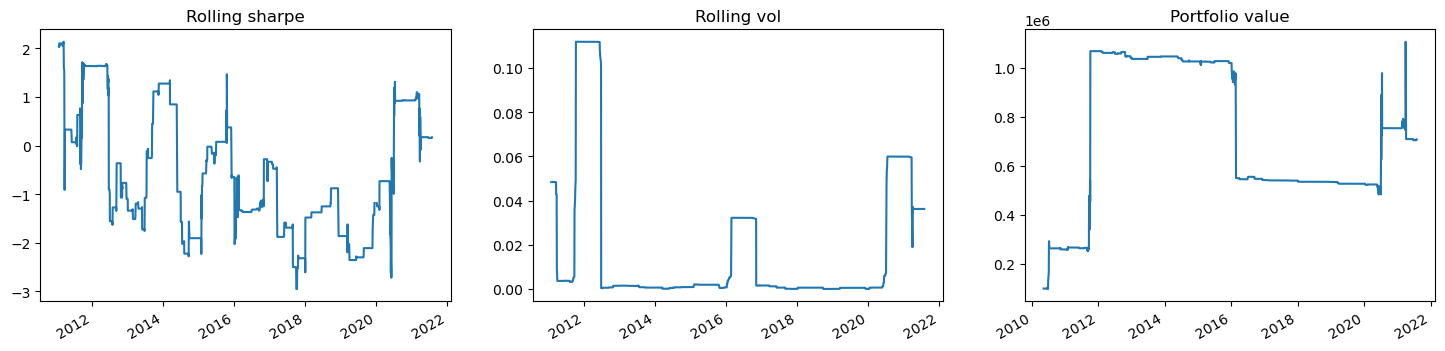

In [85]:
result = show_rolling_stats(result, 180)